In [ ]:
from collections import Counter
from typing import Tuple, List
import numpy as np
from networkx import MultiGraph
from networkx import nx
from sympy.combinatorics import Permutation
import matplotlib.pyplot as plt

In [ ]:
class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.node_info = self.build_node_info()  # print dictionary for [sigma, alpha, phi]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])

   

    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
#         if len(self.code_graph.neighbors(edge)) < 2:
#             boundary1 = []
        # else:
        boundary1 = Counter([x[1] for x in self.code_graph.edges(edge) if x[1] in self.sigma_dict])
        odd_boundaries = [x for x in boundary1 if boundary1[x] % 2]
        # [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return odd_boundaries

    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face node
        """
        # boundary2 = [node for node in self.code_graph.neighbors(face) if node in self.alpha_dict]
        boundary2 = Counter([x[1] for x in self.code_graph.edges(face) if x[1] in self.alpha_dict])
        odd_boundaries = [x for x in boundary2 if boundary2[x] % 2]
        return odd_boundaries

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        # coboundary = self.code_graph.neighbors(star)
        coboundary1 = Counter([x[1] for x in self.code_graph.edges(star)])
        odd_coboundaries = [x for x in coboundary1 if coboundary1[x] % 2]
        return odd_coboundaries

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        # coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        coboundary2 = Counter([x[1] for x in self.code_graph.edges(edge) if x[1] in self.phi_dict])
        odd_coboundaries = [x for x in coboundary2 if coboundary2[x] % 2]
        return odd_coboundaries

    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list


    
    

    def vertex_basis(self):
        self.v_basis_dict = dict()
        self.v_dict = dict()
        A = np.eye(len(self.sigma), dtype=np.uint8)
        for count, cycle in enumerate(self.sigma):
            self.v_dict[cycle] = count
            self.v_basis_dict[cycle] = A[count, :].T
        return (self.v_basis_dict)

    def edge_basis(self):
        self.e_basis_dict = dict()
        self.e_dict = dict()
        B = np.eye(len(self.alpha), dtype=np.uint8)
        for count, cycle in enumerate(self.alpha):
            self.e_dict[cycle] = count
            self.e_basis_dict[cycle] = B[count, :].T
        return (self.e_basis_dict)

    def face_basis(self):
        self.f_basis_dict = dict()
        self.f_dict = dict()
        C = np.eye(len(self.phi), dtype=np.uint8)
        for count, cycle in enumerate(self.phi):
            self.f_dict[cycle] = count
            self.f_basis_dict[cycle] = C[count, :].T
        return (self.f_basis_dict)

    
    
    
    
    def d_2(self):
        self.D2 = np.zeros(len(self.e_dict), dtype=np.uint8)
        for cycle in self.phi:
            bd = self.boundary_2(cycle)
            if bd != []:
                image = sum([self.e_basis_dict[edge] for edge in bd])
            else:
                image = np.zeros(len(self.e_dict))
            self.D2 = np.vstack((self.D2, image))
        self.D2 = np.array(self.D2[1:, :]).T
        return self.D2, self.D2.shape

    
    def d_1(self):
        self.D1 = np.zeros(len(self.v_dict), dtype=np.uint8)
        for cycle in self.alpha:
            bd = self.boundary_1(cycle)
            if bd != []:
                image = sum([self.v_basis_dict[vertex] for vertex in bd])
            else:
                bd = np.zeros(len(self.e_dict))
            self.D1 = np.vstack((self.D1, image))
        self.D1 = np.array(self.D1[1:, :]).T
        return self.D1, self.D1.shape

   
    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)

    def draw(self, node_type='', layout=''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices
        corresponding to the qubit indices for the surface code
        """
        if node_type not in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        elif layout == 'spring':
            pos = nx.spring_layout(self.code_graph)
        elif layout == 'spectral':
            pos = nx.spectral_layout(self.code_graph)
        elif layout == 'planar':
            pos = nx.planar_layout(self.code_graph)
        elif layout == 'shell':
            pos = nx.shell_layout(self.code_graph)
        elif layout == 'circular':
            pos = nx.circular_layout(self.code_graph)
        elif layout == 'spiral':
            pos = nx.spiral_layout(self.code_graph)
        elif layout == 'random':
            pos = nx.random_layout(self.code_graph)
        else:
            raise ValueError(
                "no layout defined: try one of these: " +
                "['spring','spectral','planar','shell','circular','spiral','random']")
            # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                               nodelist=list(self.alpha),
                               node_color='c',
                               node_size=500,
                               alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                               nodelist=list(self.sigma),
                               node_color='b',
                               node_size=500,
                               alpha=0.6)
        # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                               nodelist=list(self.phi),
                               node_color='r',
                               node_size=500,
                               alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels = {}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node] = f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node] = f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node] = f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node] = f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node] = f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node] = f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show()  # display

In [ ]:
sigma = ((0,1,2), (3,4,5), (6,7,8,9))
alpha = ((0,3),(1,4),(2,6),(5,7),(8,9))
SCG = SurfaceCodeGraph(sigma, alpha)

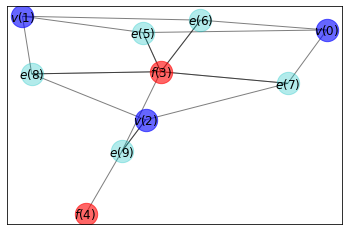

In [ ]:
SCG.node_info
SCG.genus()
SCG.face_basis()
SCG.vertex_basis()
SCG.edge_basis()
SCG.del_1([(0,3)])
SCG.boundary_1((0,3))
SCG.del_1([(1,4)])
SCG.boundary_1((1,4))
SCG.del_1([(2,6)])
SCG.boundary_1((2,6))
SCG.del_1([(5,7)])
SCG.boundary_1((5,7))
SCG.del_1([(8,9)])
SCG.boundary_1((8,9))
SCG.d_1()
SCG.d_2()
SCG.D1
SCG.D2

SCG.draw('dict', layout = 'spring')

In [ ]:
def rowSwap(A, i, j):
    temp = np.copy(A[i, :])
    A[i, :] = A[j, :]
    A[j, :] = temp

def colSwap(A, i, j):
    temp = np.copy(A[:, i])
    A[:, i] = A[:, j]
    A[:, j] = temp

def scaleCol(A, i, c):
    A[:, i] *= int(c) * np.ones(A.shape[0], dtype=np.int64)

def scaleRow(A, i, c):
    A[i, :] = np.array(A[i, :], dtype=np.float64) * c * np.ones(A.shape[1], dtype=np.float64)

def colCombine(A, addTo, scaleCol, scaleAmt):
    A[:, addTo] += scaleAmt * A[:, scaleCol]

def rowCombine(A, addTo, scaleRow, scaleAmt):
    A[addTo, :] += scaleAmt * A[scaleRow, :]

In [ ]:
def simultaneousReduce(A, B):
    if A.shape[1] != B.shape[0]:
        raise Exception("Matrices have the wrong shape.")

    numRows, numCols = A.shape

    i, j = 0, 0
    while True:
        if i >= numRows or j >= numCols:
            break

        if A[i, j] == 0:
            nonzeroCol = j
            while nonzeroCol < numCols and A[i, nonzeroCol] == 0:
                nonzeroCol += 1

            if nonzeroCol == numCols:
                i += 1
                continue

            colSwap(A, j, nonzeroCol)
            rowSwap(B, j, nonzeroCol)

        pivot = A[i, j]
        scaleCol(A, j, 1.0 / pivot)
        scaleRow(B, j, 1.0 / pivot)

        for otherCol in range(0, numCols):
            if otherCol == j:
                continue
            if A[i, otherCol] != 0:
                scaleAmt = -A[i, otherCol]
                colCombine(A, otherCol, j, scaleAmt)
                rowCombine(B, j, otherCol, -scaleAmt)

        i += 1;
        j += 1

    return A%2, B%2

In [ ]:
def finishRowReducing(B):
    numRows, numCols = B.shape

    i, j = 0, 0
    while True:
        if i >= numRows or j >= numCols:
            break

        if B[i, j] == 0:
            nonzeroRow = i
            while nonzeroRow < numRows and B[nonzeroRow, j] == 0:
                nonzeroRow += 1

            if nonzeroRow == numRows:
                j += 1
                continue

            rowSwap(B, i, nonzeroRow)

        pivot = B[i, j]
        scaleRow(B, i, 1.0 / pivot)

        for otherRow in range(0, numRows):
            if otherRow == i:
                continue
            if B[otherRow, j] != 0:
                scaleAmt = -B[otherRow, j]
                rowCombine(B, otherRow, i, scaleAmt)

        i += 1;
        j += 1

    return B%2

In [ ]:
def numPivotCols(A):
    z = np.zeros(A.shape[0])
    return [np.all(A[:, j] == z) for j in range(A.shape[1])].count(False)


def numPivotRows(A):
    z = np.zeros(A.shape[1])
    return [np.all(A[i, :] == z) for i in range(A.shape[0])].count(False)


def bettiNumber(d_k, d_kplus1):
    A, B = np.copy(d_k), np.copy(d_kplus1)
    simultaneousReduce(A, B)
    finishRowReducing(B)

    dimKChains = A.shape[1]
    print("dim 1-chains:",dimKChains)
    kernelDim = dimKChains - numPivotCols(A)
    print("dim ker d_1:",kernelDim)
    imageDim = numPivotRows(B)
    print("dim im d_2:",imageDim)

    return "dim homology:",kernelDim - imageDim

In [ ]:
simultaneousReduce(SCG.D1.astype('float64'), SCG.D2.astype('float64'))
finishRowReducing(SCG.D2.astype('float64'))
numPivotCols(SCG.D2.astype('float64'))
numPivotRows(SCG.D2.astype('float64'))
bettiNumber(SCG.D1.astype('float64'), SCG.D2.astype('float64'))

dim 1-chains: 5
dim ker d_1: 2
dim im d_2: 1


('dim homology:', 1)